In [1]:
import os 
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm

sys.path.append('E:\\PycarmProjects2\\reservoir_computing')
%matplotlib inline

### Import models and datagenerator

In [2]:
from Model.ESN_Control_Euler import Esn
from DataGenerator.Lorenz import Lorenz
from utils.utils import downsample_curvature

# Bifuraction prediction

### Step 1: Initialize data, bifuraction parameter $\rho \approx 24.7$

In [3]:
def compute_fix_point(rho):
    return np.array([np.sqrt(8 / 3 * (rho - 1)), np.sqrt(8 / 3 * (rho - 1)), rho - 1])

delta_t = 0.01
rhos = [23., 24.]
pertubation = np.array([0.6, 1.1, 0.])
scale = np.array([4., 2.8, -4., -2.8])
initial_point = np.stack([compute_fix_point(rhos[i%2]) + scale[i] * pertubation for i in range(4)], axis=0)
t_train = 200
t_waste = 20
n_waste = int(t_waste / delta_t)
n = int((t_train + t_waste) / delta_t)
t_ind = np.arange(n_waste, n)
t_ind = np.concatenate([t_ind, t_ind + n, t_ind + 2 * n, t_ind + 3 * n])
total_data = []
for i in tqdm(range(4)):
    model = Lorenz(10., rhos[i%2], 8 / 3, delta_t, *initial_point[i])
    data = model.propagate(t_train + t_waste, 0)
    total_data.append(data)
total_data = np.concatenate(total_data, axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]


compression ratio: 0.18
compression ratio: 0.40
compression ratio: 0.20
compression ratio: 0.44


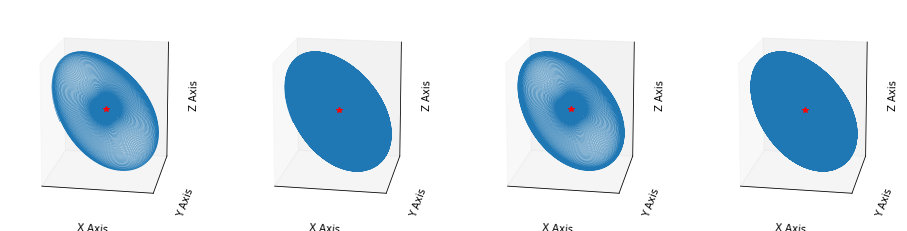

In [4]:
total_data_split = total_data.reshape((3, 4, -1))
fig = plt.figure(figsize=(16, 4))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    states =  total_data_split[:, i, :]
    states, ind = downsample_curvature(states, 0.1, np.array([100, 15]))
    ax.plot(states[0, :], states[1, :], states[2, :], lw=0.5)
    x0, y0, z0 = compute_fix_point(rhos[i%2])
    ax.plot([x0], [y0], [z0], "r*")
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    # ax.set_title("Lorenz Attractor")
    ax.grid(False)
    ax.view_init(elev=15,  # 仰角
                 azim=100,  # 方位角
                 )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    # ax.axis('off')
#     ax.xaxis.pane.fill = False  # Left pane
#     ax.yaxis.pane.fill = False  # Right pane


Simulating and fitting reservoir
harvesting states...
train length 88000
|Progress: [######### ] 100.0% in 16 secmse: 2.217099509090384e-09

Predicting reservoir

 Plot result
compression ratio: 0.64
compression ratio: 0.40


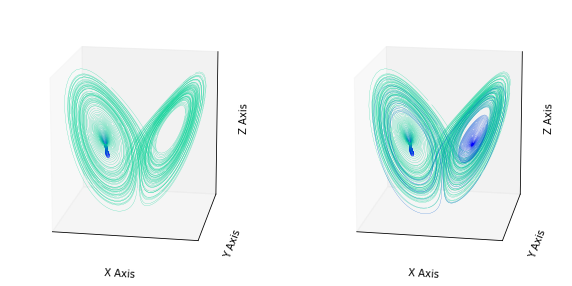

In [5]:
nF = 200
elev, azim = [15, 100]  # Azimuth 方位角， elevation 仰角
nF = 200
color = plt.get_cmap("winter")
winter = color(np.linspace(0, 1, int(1.2 * nF)))
base_num = 1

def plot_curve(data, contorl_par, index):
    global base_num
    global fig
    ax = fig.add_subplot(1, 2, base_num, projection='3d')
    base_num += 1
    ll = data.shape[1]
    chunks = np.floor(np.linspace(0, ll, nF)).astype(np.int)
    for i in range(1, nF):
        col = winter[contorl_par[index[chunks[i - 1]]]]
        ax.plot(data[0, chunks[i - 1]:chunks[i]], data[1, chunks[i - 1]:chunks[i]], data[2, chunks[i - 1]:chunks[i]],
                lw=0.2, color=col)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    # ax.set_title("Lorenz Attractor")
    ax.grid(False)
    ax.view_init(elev=elev,  # 仰角
                 azim=azim,  # 方位角
                 )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    # ax.axis('off')
#     ax.xaxis.pane.fill = False  # Left pane
#     ax.yaxis.pane.fill = False  # Right pane
    return None



# eta = 0.1
# total_data = total_data + np.random.multivariate_normal(np.zeros(3), cov=np.eye(3) * eta, size=4 * n).T

# reservoir states

esn = Esn(n_inputs=3,
          n_reservoir=200,
          n_outputs=3,
          leaky_rate=1.,
          spectral_radius=0.95,
          random_state=None,
          sparsity=0.1,
          ridge_param=1e-7,
          delta_t=delta_t,
          silent=False,
          washout=1000,
          valid_index=t_ind)
control_par = np.ones((1, total_data_split.shape[-1]))
control_par = np.concatenate([control_par * 0, control_par * 1, control_par * 0, control_par * 1], axis=1)
print("\nSimulating and fitting reservoir")
esn.fit(total_data, control_par)
# esn.fit_da(total_data, control_par, ensembles=400, eta=eta, initial_zero=False)

nT = 6000
n_forward = 9000
n_backward = 15000
control_par = np.concatenate([np.linspace(0, 5, nT), 5 * np.ones(n_forward), np.linspace(5, 0, nT), 0 * np.ones(n_backward)])
control_par = control_par[np.newaxis, :, ]
print("\nPredicting reservoir")
output = esn.forward(control_par)

prediction1 = output[:, :(nT + n_forward)]
prediction2 = output

print("\n Plot result")


# print('ax.elev {}'.format(elev))  # default 30
# print('ax.azim {}'.format(azim))  # default -60
downsample_pred1, ind1 = downsample_curvature(prediction1, 0.1, np.array([azim, elev]))
downsample_pred2, ind2 = downsample_curvature(prediction2, 0.1, np.array([azim, elev]))

control_par1 = control_par[:, :(nT + n_forward)].squeeze()
control_par2 = control_par[:, :].squeeze()

cp1 = np.floor((control_par1 - np.min(control_par1)) / (
        np.max(control_par1) - np.min(control_par1)) * (nF - 3) + 1)
cp2 = np.floor((control_par2 - np.min(control_par2)) / (
        np.max(control_par2) - np.min(control_par2)) * (nF - 3) + 1)

cp1 = cp1.astype(np.int)
cp2 = cp2.astype(np.int)

save_res = False
if save_res:
    np.savez("result/forward_predict_bifuraction.npz", data=downsample_pred1, index=ind1, c=control_par1)
    np.savez("result/backward_predict_bifuraction.npz", data=downsample_pred2, index=ind2, c=control_par2)

fig = plt.figure(figsize=(10, 5))
plot_curve(downsample_pred1, cp1, ind1)
plot_curve(downsample_pred2, cp2, ind2)

In [6]:
esn = Esn(n_inputs=3,
          n_reservoir=200,
          n_outputs=3,
          leaky_rate=1.,
          spectral_radius=0.95,
          random_state=None,
          sparsity=0.1,
          ridge_param=1e-7,
          delta_t=delta_t,
          silent=False,
          washout=1000,
          valid_index=t_ind)
control_par = np.ones((1, total_data_split.shape[-1]))
control_par = np.concatenate([control_par * 0, control_par * 1, control_par * 0, control_par * 1], axis=1)
print("\nSimulating and fitting reservoir")
# esn.fit(total_data, control_par)
eta = 0.0000001
esn.fit_da(total_data, control_par, ensembles=500, eta=eta, initial_zero=False)

nT = 6000
n_forward = 9000
n_backward = 15000
control_par = np.concatenate([np.linspace(0, 5, nT), 5 * np.ones(n_forward), np.linspace(5, 0, nT), 0 * np.ones(n_backward)])
control_par = control_par[np.newaxis, :, ]
print("\nPredicting reservoir")
output = esn.forward(control_par)

prediction1 = output[:, :(nT + n_forward)]
prediction2 = output

print("\n Plot result")


# print('ax.elev {}'.format(elev))  # default 30
# print('ax.azim {}'.format(azim))  # default -60
downsample_pred1, ind1 = downsample_curvature(prediction1, 0.1, np.array([azim, elev]))
downsample_pred2, ind2 = downsample_curvature(prediction2, 0.1, np.array([azim, elev]))

control_par1 = control_par[:, :(nT + n_forward)].squeeze()
control_par2 = control_par[:, :].squeeze()

cp1 = np.floor((control_par1 - np.min(control_par1)) / (
        np.max(control_par1) - np.min(control_par1)) * (nF - 3) + 1)
cp2 = np.floor((control_par2 - np.min(control_par2)) / (
        np.max(control_par2) - np.min(control_par2)) * (nF - 3) + 1)

cp1 = cp1.astype(np.int)
cp2 = cp2.astype(np.int)

save_res = False
if save_res:
    np.savez("result/forward_predict_bifuraction.npz", data=downsample_pred1, index=ind1, c=control_par1)
    np.savez("result/backward_predict_bifuraction.npz", data=downsample_pred2, index=ind2, c=control_par2)

fig = plt.figure(figsize=(10, 5))
plot_curve(downsample_pred1, cp1, ind1)
plot_curve(downsample_pred2, cp2, ind2)


Simulating and fitting reservoir
harvesting states...
train length 88000
|Progress: [######### ] 100.0% in 16 secmse: 1.9819650880737753e-09

 da
n 22000
|Progress: [######### ] 100.0% in 1001 sec
Predicting reservoir

 Plot result
compression ratio: 0.10
compression ratio: 0.04


ValueError: num must be 1 <= num <= 2, not 3

<Figure size 720x360 with 0 Axes>